In [1]:
using Distributions
using LinearAlgebra
import ProgressMeter
using WAV
using Plots
using AIDA

In [2]:
# clean speech
cl, fs = wavread("../sound/NOIZEUS/clean/sp01.wav")
σ² = 0.0001
# white noise
wn = sqrt(σ²)*randn(length(cl))
# noised speech
ns = cl .+ wn

22529×1 Matrix{Float64}:
 -0.0054525622323349605
 -0.010944642037806696
 -0.006236093018071448
 -0.0017321767544150922
 -0.0012408125623715057
  0.002713627450191603
 -0.007256677275062889
 -0.0015175253514386686
  0.023237344772572104
  0.008982604530563064
  0.0029504370417546793
 -0.0019158914557642873
  0.009281091107076762
  ⋮
  0.004843098280970128
  0.014324908311525563
 -0.018735840258257922
 -0.00993212871813658
  0.00533753067370217
  0.003992883725154324
  0.015571273967826885
 -0.004475955043615925
  0.013851725661014423
 -0.014239800041269433
 -0.03639206304592614
  0.01746324376123539

In [3]:
cl_seg = get_frames(cl, fs)
ns_seg = get_frames(ns, fs)
totseg = size(ns_seg, 1)

376

In [4]:
ar_order = 10
vmp_iter = 50
fe_ar = zeros(totseg, vmp_iter)
fe_gaussian = zeros(totseg, vmp_iter);

In [8]:
ProgressMeter.@showprogress for segnum in 1:totseg
    inputs, outputs = ar_ssm(ns_seg[segnum, :], ar_order)
    _, _, _, _, fe = lar_inference(outputs, vmp_iter, priors=Dict(:aτ => 1e-4, :bτ => 1e-4, 
                                                                  :aγ => 1e-4, :bγ => 1e-4, 
                                                                   :order => ar_order))
    fe_ar[segnum, :] = fe
    
    _, _, fe = inference_gaussian(outputs, vmp_iter, priors=Dict(:aτ => 1e-4, :bτ => 1e-4))
    
    fe_gaussian[segnum, :] = fe
end

Progress: 100%|█████████████████████████████████████████| Time: 0:04:35


In [9]:
vad = [x[end] < y[end] for (x, y) in zip(eachrow(fe_ar), eachrow(fe_gaussian))];

In [10]:
rsegs = findall(isequal(1), vad)
nsegs = findall(isequal(0), vad);

In [11]:
rseg = rand(rsegs)
nseg = rand(nsegs)
println("$(rseg), $(nseg)")

53, 358


In [12]:
inv(var(sum([ns_seg[nseg, :] for nseg in nsegs])))

21.803021479043174

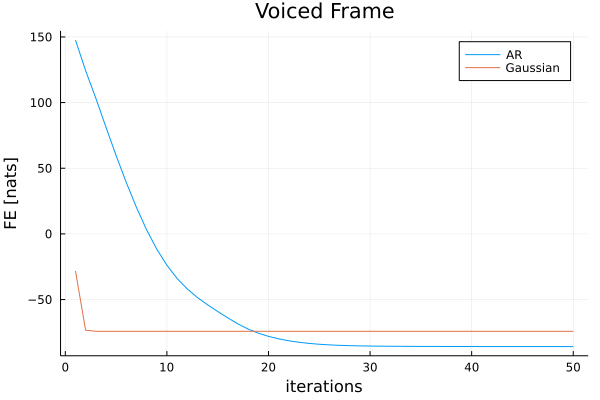

In [13]:
plot(fe_ar[rseg, :], label="AR")
plot!(fe_gaussian[rseg, :], label="Gaussian", ylabel="FE [nats]", xlabel="iterations", title="Voiced Frame")

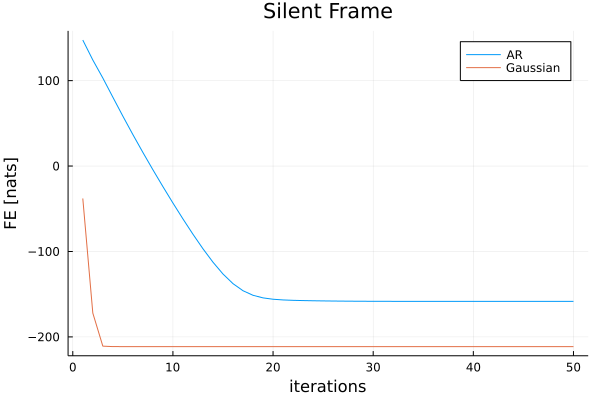

In [14]:
plot(fe_ar[nseg, :], label="AR")
plot!(fe_gaussian[nseg, :], label="Gaussian", ylabel="FE [nats]", xlabel="iterations", title="Silent Frame")

In [15]:
println("$(fe_gaussian[rseg, :][end]), $(fe_ar[rseg, :][end])")

-74.17769052509604, -85.8467316942806


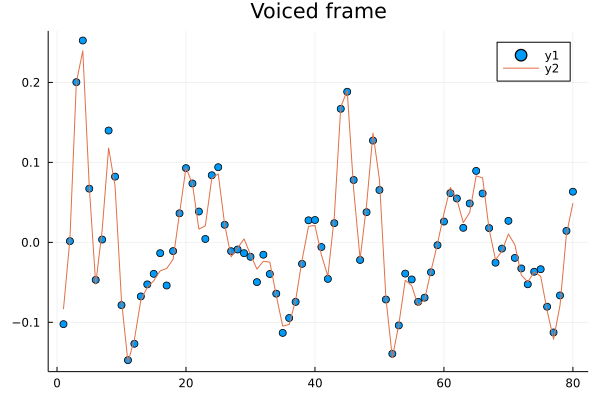

In [16]:
scatter(ns_seg[rseg, :])
plot!(cl_seg[rseg, :], title="Voiced frame")

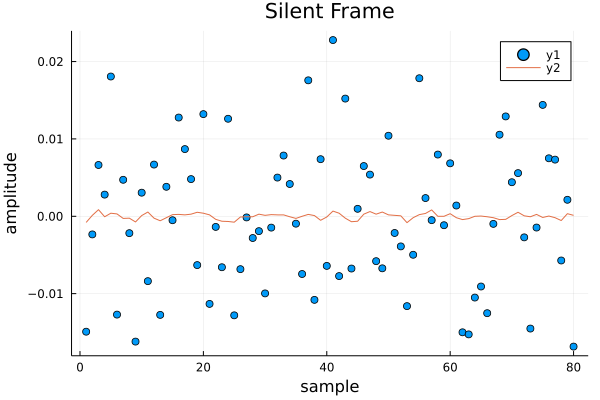

In [17]:
scatter(ns_seg[nseg, :])
plot!(cl_seg[nseg, :], ylabel="amplitude", xlabel="sample", title="Silent Frame")

In [19]:
# check = get_signal(hcat([ns_seg[nseg, :] for nseg in nsegs]...)', 8000)
# using WAV
# wavwrite(check, fs, "check.wav")